In [ ]:
import pandas as pd

dfbtc = pd.read_csv("/content/Bitcoin Historical Data.csv")

dfbtc['Price'] = dfbtc['Price'].astype(str).str.replace(',', '', regex=False)
dfbtc['Price'] = pd.to_numeric(dfbtc['Price'], errors='coerce')

dfstock = pd.read_csv("/content/SP500.csv")

#set to datetime index

dfbtc['Date'] = pd.to_datetime(dfbtc['Date'])
dfbtc = dfbtc.set_index('Date').sort_index()

dfstock['observation_date'] = pd.to_datetime(dfstock['observation_date'])
dfstock = dfstock.set_index('observation_date').sort_index()

In [ ]:
#filter out the dates

start_date = '11/09/2015'
end_date = '03/23/2025'
filtered_dfbtc = dfbtc.loc[start_date:end_date]
filtered_dfstock = dfstock.loc[start_date:end_date]


In [ ]:
filtered_dfbtc.index = pd.to_datetime(filtered_dfbtc.index)
filtered_dfstock.index = pd.to_datetime(filtered_dfstock.index)

#merge two datasets
merged_df = filtered_dfbtc.join(filtered_dfstock, how='outer')
columns_to_drop = ['Open', 'High', 'Low', 'Vol.', 'Change %']
merged_df = merged_df.drop(columns=columns_to_drop)

merged_df = merged_df.rename(columns={'Price': 'BTC'})

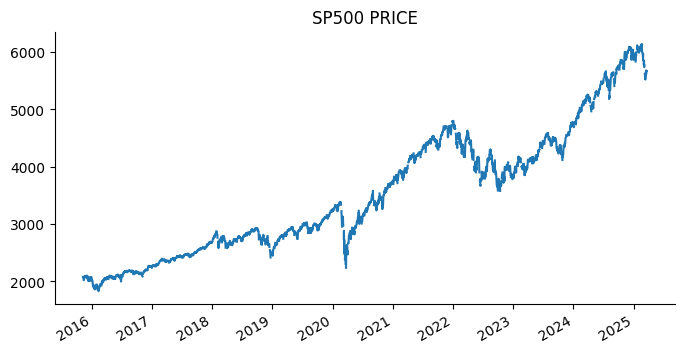

In [ ]:
from matplotlib import pyplot as plt
merged_df['SP500'].plot(kind='line', figsize=(8, 4), title='SP500 PRICE')
plt.gca().spines[['top', 'right']].set_visible(False)

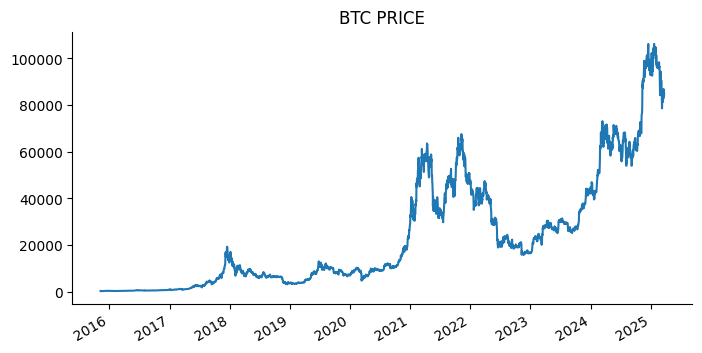

In [ ]:
from matplotlib import pyplot as plt
merged_df['BTC'].plot(kind='line', figsize=(8, 4), title='BTC PRICE')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import numpy as np

merged_df['BTC'] = pd.to_numeric(merged_df['BTC'], errors='coerce')
merged_df['SP500'] = pd.to_numeric(merged_df['SP500'], errors='coerce')

merged_df['BTC_Log_Return'] = np.log(merged_df['BTC'] / merged_df['BTC'].shift(1))
merged_df['SP500_Log_Return'] = np.log(merged_df['SP500'] / merged_df['SP500'].shift(1))

# Remove dropna to keep all dates up to 2025, even if BTC_Log_Return is NaN
# merged_df = merged_df.dropna(subset=['BTC_Log_Return', 'SP500_Log_Return'])
print(f"merged_df after log return calculation end date: {merged_df.index.max()}")
display(merged_df.tail())

merged_df after log return calculation end date: 2025-03-23 00:00:00


,BTC,SP500,BTC_Log_Return,SP500_Log_Return
2025-03-19,86841.0,5675.29,0.048628,0.010741
2025-03-20,84208.1,5662.89,-0.030788,-0.002187
2025-03-21,84073.3,5667.56,-0.001602,0.000824
2025-03-22,83840.5,NaN,-0.002773,NaN
2025-03-23,84789.5,NaN,0.011256,NaN


In [ ]:
# drop missing values created by the log return calculation
merged_df.dropna(subset=['BTC_Log_Return', 'SP500_Log_Return'], inplace=True)

# double check for infinite values
import numpy as np
merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
#graph BTC and SP500 Log Returns
import plotly.graph_objects as pg

fig = pg.Figure()

fig.add_trace(pg.Scatter(
    x=merged_df.index,
    y=merged_df['BTC_Log_Return'],
    mode='lines',
    name='Bitcoin Log Returns'
))

fig.add_trace(pg.Scatter(
    x=merged_df.index,
    y=merged_df['SP500_Log_Return'],
    mode='lines',
    name='SP500 Log Returns'
))

fig.update_layout(
    title='Daily Log Returns of BTC and S500 Between 2015-2025',
    xaxis_title='Date',
    yaxis_title='Log Returns',
    hovermode='x unified'
)

fig.show()

In [ ]:
#find the correlation rate between log returns

merged_df[["BTC_Log_Return", "SP500_Log_Return"]].corr()

,BTC_Log_Return,SP500_Log_Return
BTC_Log_Return,1.000000,0.169576
SP500_Log_Return,0.169576,1.000000


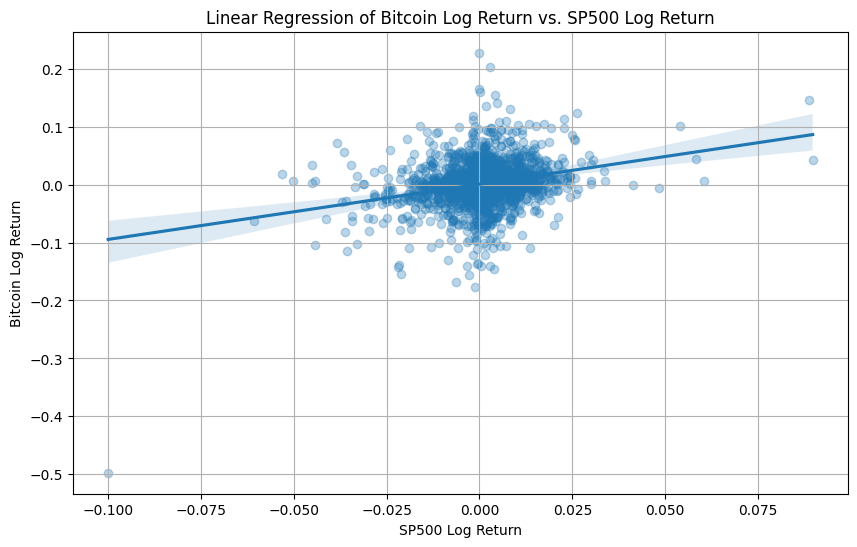

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the regression between Log Returns
plt.figure(figsize=(10, 6))
sns.regplot(x=merged_df['SP500_Log_Return'], y=merged_df['BTC_Log_Return'], scatter_kws={'alpha':0.3})
plt.title('Linear Regression of Bitcoin Log Return vs. SP500 Log Return')
plt.xlabel('SP500 Log Return')
plt.ylabel('Bitcoin Log Return')
plt.grid(True)
plt.show()

In [ ]:
#find the correlation rate between prices

merged_df[["BTC", "SP500"]].corr()

,BTC,SP500
BTC,1.000000,0.932404
SP500,0.932404,1.000000


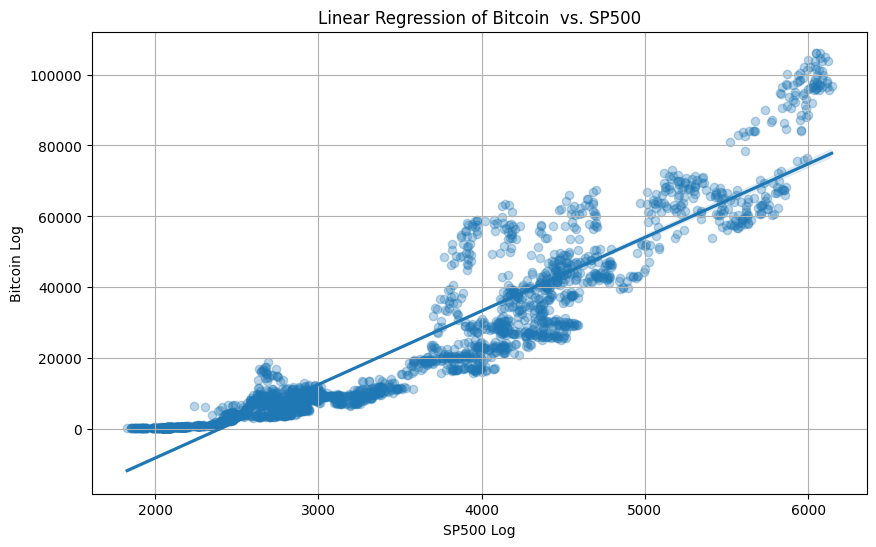

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the regression between prices
plt.figure(figsize=(10, 6))
sns.regplot(x=merged_df['SP500'], y=merged_df['BTC'], scatter_kws={'alpha':0.3})
plt.title('Linear Regression of Bitcoin  vs. SP500')
plt.xlabel('SP500 Log')
plt.ylabel('Bitcoin Log')
plt.grid(True)
plt.show()

In [ ]:
#calculate rolling standard deviation which helps to understand market votality

merged_df['SP500_Log_Return'] = merged_df['SP500_Log_Return'].ffill()
merged_df['rolling_std_SP500'] = merged_df['SP500_Log_Return'].rolling(window=30).std()

merged_df['BTC_Log_Return'] = merged_df['BTC_Log_Return'].ffill()
merged_df['rolling_std_BTC'] = merged_df['BTC_Log_Return'].rolling(window=30).std()

merged_df['rolling_std_BTC']


,rolling_std_BTC
2015-12-09,NaN
2015-12-10,NaN
2015-12-11,NaN
2015-12-14,NaN
2015-12-15,NaN
...,...
2025-03-17,0.030785
2025-03-18,0.029791
2025-03-19,0.030949
2025-03-20,0.031298


In [ ]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# Prepare the data for VAR, we only use the log return columns for the model
data_for_var = merged_df[['BTC_Log_Return', 'SP500_Log_Return']]

#Initialize and Fit the Model
model = VAR(data_for_var)
ß
# Select the best lag order
lag_selection = model.select_order(maxlags=30)
print(lag_selection.summary())

# Fit the model using the best lag (usually based on AIC)
optimal_lag = lag_selection.aic
model_fitted = model.fit(optimal_lag)

# 3. Forecast the "Next Step"
# We need the last 'optimal_lag' days of data to predict the future
forecast_input = data_for_var.values[-optimal_lag:]
n_steps = 5  # Predict next 5 days
forecast = model_fitted.forecast(y=forecast_input, steps=n_steps)

# Convert forecast to a readable DataFrame
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=data_for_var.index[-1] + pd.Timedelta(days=1), periods=n_steps), columns=data_for_var.columns)

print("\nForecasted Log Returns for the next 5 days:")
display(forecast_df)

# Interpretation Logic
print("\n--- PREDICTION ---")
next_day_btc_forecast = forecast_df.iloc[0]['BTC_Log_Return']
if next_day_btc_forecast > 0:
    print(f"Prediction: BTC price is expected to go UP (Predicted Log Return: {next_day_btc_forecast:.6f})")
else:
    print(f"Prediction: BTC price is expected to go DOWN (Predicted Log Return: {next_day_btc_forecast:.6f})")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -15.50      -15.49   1.857e-07      -15.50
1       -15.52     -15.50*   1.822e-07      -15.51
2       -15.52      -15.50   1.814e-07      -15.51
3       -15.52      -15.49   1.814e-07      -15.51
4       -15.52      -15.48   1.817e-07      -15.50
5       -15.52      -15.47   1.817e-07      -15.50
6       -15.52      -15.46   1.814e-07      -15.50
7       -15.54      -15.47   1.781e-07      -15.51
8       -15.55      -15.46   1.769e-07     -15.52*
9       -15.55      -15.45   1.771e-07      -15.51
10      -15.55      -15.44   1.769e-07      -15.51
11     -15.55*      -15.43  1.766e-07*      -15.51
12      -15.55      -15.42   1.772e-07      -15.50
13      -15.54      -15.41   1.777e-07      -15.49
14      -15.54      -15.40   1.780e-07      -15.49
15      -15.54      -15.39   1.778e-07      -15.49
16      -15.54      -15.38   1.

,BTC_Log_Return,SP500_Log_Return
2025-03-22,0.000907,-0.002791
2025-03-23,0.002041,0.002989
2025-03-24,0.005245,0.002523
2025-03-25,-0.003009,-0.000331
2025-03-26,0.007157,0.002117



--- PREDICTION ---
Prediction: BTC price is expected to go UP (Predicted Log Return: 0.000907)
